<a href="https://colab.research.google.com/github/hanrach/marked-beetle-analysis/blob/main/0827ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Dataset exploration**

In [ ]:
filenames = os.listdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")
filenames[1]


'PaperedControl21v_light.tif'

In [ ]:
train_images=[]
for filename in filenames:
    if 'light' not in filename:
      if filename.startswith('Papered') or filename.startswith('NoPapered'):
        train_images.append(filename)
print(f"Number of Train images: {len(train_images)}") #filename.startswith('Pink')

Number of Train images: 757


In [ ]:
categories = []
for filename in train_images:
    if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('marked')
    if filename.startswith('NoPapered'):
        categories.append('unmarked')
len(categories)

757

In [ ]:
df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
df

,filename,category
0,PaperedControl21d.tif,marked
1,PaperedControl22v.tif,marked
2,PaperedControl22d.tif,marked
3,PaperedControl23v.tif,marked
4,PaperedControl23d.tif,marked
...,...,...
752,PaperedControl19v.tif,marked
753,PaperedControl19d.tif,marked
754,PaperedControl20v.tif,marked
755,PaperedControl20d.tif,marked


In [ ]:
dfmark=df[df['category']=='marked']
dfmark

,filename,category
0,PaperedControl21d.tif,marked
1,PaperedControl22v.tif,marked
2,PaperedControl22d.tif,marked
3,PaperedControl23v.tif,marked
4,PaperedControl23d.tif,marked
...,...,...
752,PaperedControl19v.tif,marked
753,PaperedControl19d.tif,marked
754,PaperedControl20v.tif,marked
755,PaperedControl20d.tif,marked


In [ ]:
dfunmark=df[df['category']=='unmarked']
dfunmark

,filename,category
336,NoPaperedGreen20v.tif,unmarked
337,NoPaperedGreen20d.tif,unmarked
338,NoPaperedGreen38v.tif,unmarked
339,NoPaperedGreen38d.tif,unmarked
340,NoPaperedGreen26v.tif,unmarked
...,...,...
732,NoPaperedGreen8v.tif,unmarked
733,NoPaperedGreen9v.tif,unmarked
734,NoPaperedGreen9d.tif,unmarked
735,NoPaperedGreen10v.tif,unmarked


In [ ]:
df['category'].value_counts()

marked      479
unmarked    278
Name: category, dtype: int64

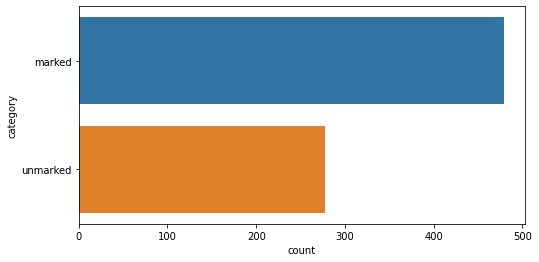

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(y="category", data=df);

In [ ]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", filenames[1]))
image.shape

(1944, 2592, 3)

In [ ]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [ ]:
tmp_df = df.sample(9)
tmp_df

,filename,category
651,PaperedMixed33d.tif,marked
386,NoPaperedGreen39v.tif,unmarked
686,NoPaperedMixed1d.tif,unmarked
71,PaperedControl56d.tif,marked
41,PaperedControl41d.tif,marked
521,NoPaperedMixed18d.tif,unmarked
166,PaperedTransparent25v.tif,marked
589,PaperedMixed2d.tif,marked
91,PaperedControl66v.tif,marked


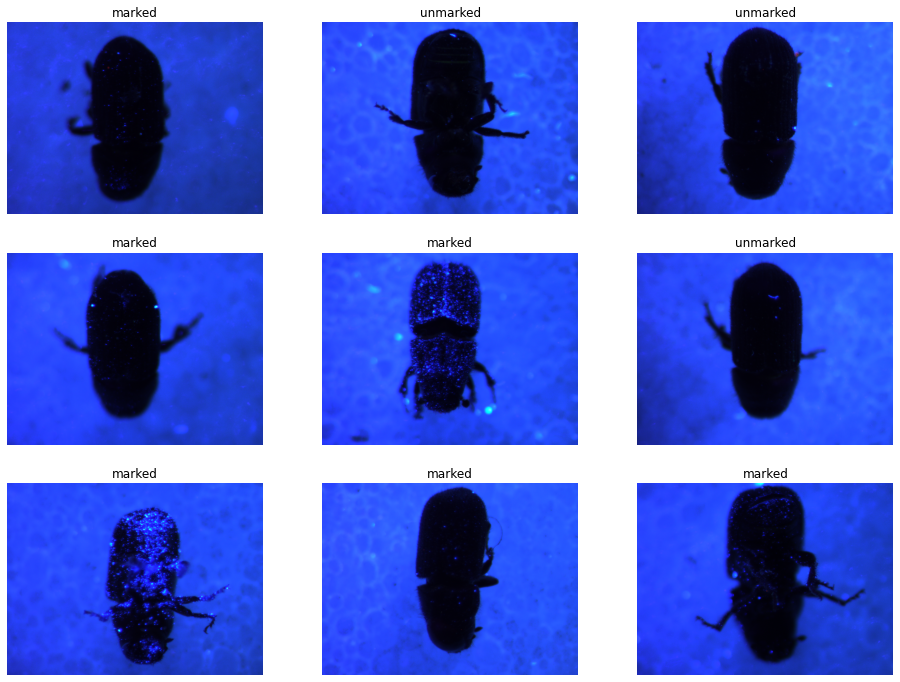

In [ ]:
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

In [ ]:
#df["category"] = df["category"].replace({0: 'NotMarked', 1: 'Marked'}) 

**Traininng and validation set**

In [ ]:
train_df1, validate_df1 = train_test_split(dfmark, test_size = 0.2, random_state = 42, stratify = dfmark['category'])
train_df1 = train_df1.reset_index(drop=True)
validate_df1 = validate_df1.reset_index(drop=True)

In [ ]:
train_df2, validate_df2 = train_test_split(dfunmark, test_size = 0.2, random_state = 42, stratify = dfunmark['category'])
train_df2 = train_df2.reset_index(drop=True)
validate_df2 = validate_df2.reset_index(drop=True)

In [ ]:
train_df=train_df1.append(train_df2)
train_df

,filename,category
0,PaperedTransparent105d.tif,marked
1,PaperedControl68d.tif,marked
2,PaperedControl34d.tif,marked
3,PaperedTransparent27d.tif,marked
4,PaperedTransparent84v.tif,marked
...,...,...
217,NoPaperedGreen59v.tif,unmarked
218,NoPaperedMixed32v.tif,unmarked
219,NoPaperedGreen45d.tif,unmarked
220,NoPaperedGreen23d.tif,unmarked


In [ ]:
validate_df=validate_df1.append(validate_df2)
validate_df

,filename,category
0,PaperedTransparent22v.tif,marked
1,PaperedTransparent88d.tif,marked
2,PaperedTransparent97d.tif,marked
3,PaperedMixed24d.tif,marked
4,PaperedTransparent42d.tif,marked
...,...,...
51,NoPaperedGreen76v.tif,unmarked
52,NoPaperedGreen85d.tif,unmarked
53,NoPaperedGreen16d.tif,unmarked
54,NoPaperedMixed7v.tif,unmarked


In [ ]:
#train_df, validate_df = train_test_split(df, test_size = 0.10, random_state = 42, stratify = df['category'])
#train_df = train_df.reset_index(drop=True)
#validate_df = validate_df.reset_index(drop=True)

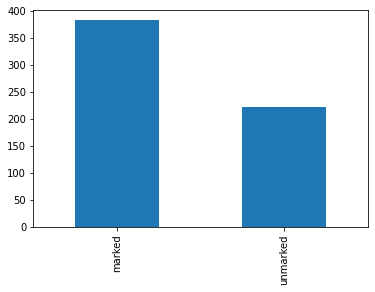

In [ ]:
train_df['category'].value_counts().plot.bar()

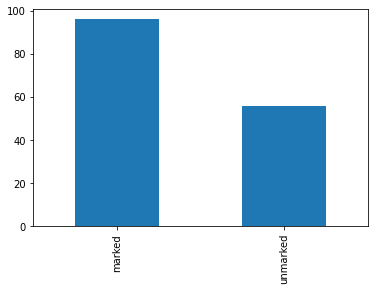

In [ ]:
validate_df['category'].value_counts().plot.bar()

In [ ]:
IMG_SIZE = 224
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2
BATCH_SIZE = 32

In [ ]:
datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    brightness_range = [0.3,0.9],
                    channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

In [ ]:
datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

In [ ]:
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 605 validated image filenames belonging to 2 classes.


In [ ]:
validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 152 validated image filenames belonging to 2 classes.


**Build the model**

In [ ]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import  Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB5,resnet50,EfficientNetB7
def create_model():
  base = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3),classes=2)
        # Freeze the pretrained weights resnet50.ResNet50
  base.trainable = False
  #for layer in base.layers[:-40]:  # Training just part of the architecture do not optimize the performance
      #layer.trainable = False
  model = Sequential()
  model.add(base)
  model.add(GlobalAveragePooling2D())
  model.add(Flatten())
  model.add(BatchNormalization())
  #model.add(Flatten())
  model.add(Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))
  return model
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [ ]:
EPOCHS = 20
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [ ]:
def Model_fit():
    
    #leaf_model = None
    
    model = create_model()
    
    '''Compiling the model'''
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['accuracy']) #'acc'
    
        # Stop training when the val_loss has stopped decreasing for 3 epochs.
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("/content/drive/MyDrive/Mymodel/27ResNet50_model.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    history = model.fit(train_set,
                             validation_data = validate_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[stop, checkpoint_cb, reduce_lr])
    model.save('model'+'.h5')  
    return history

In [ ]:
results = Model_fit()

Epoch 1/20
18/18 [==============================] - 659s 37s/step - loss: 0.9006 - accuracy: 0.6979 - val_loss: 0.7560 - val_accuracy: 0.7188


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
18/18 [==============================] - 394s 22s/step - loss: 0.6484 - accuracy: 0.7836 - val_loss: 0.4494 - val_accuracy: 0.8125
Epoch 3/20
18/18 [==============================] - 377s 21s/step - loss: 0.6931 - accuracy: 0.8255 - val_loss: 0.4774 - val_accuracy: 0.8281
Epoch 4/20
18/18 [==============================] - 375s 21s/step - loss: 0.5255 - accuracy: 0.8517 - val_loss: 0.3134 - val_accuracy: 0.8594
Epoch 5/20
18/18 [==============================] - 369s 20s/step - loss: 0.5304 - accuracy: 0.8202 - val_loss: 0.2477 - val_accuracy: 0.8828
Epoch 6/20
18/18 [==============================] - 372s 21s/step - loss: 0.4845 - accuracy: 0.8482 - val_loss: 0.3635 - val_accuracy: 0.8203
Epoch 7/20
18/18 [==============================] - 369s 21s/step - loss: 0.5582 - accuracy: 0.8342 - val_loss: 0.2525 - val_accuracy: 0.8984

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 8/20
18/18 [==============================] - 372s 21s/step 

In [ ]:
print('Train_Cat-Acc: ', max(results.history['accuracy']))
print('Val_Cat-Acc: ', max(results.history['val_accuracy']))

Train_Cat-Acc:  0.8516579270362854
Val_Cat-Acc:  0.8984375


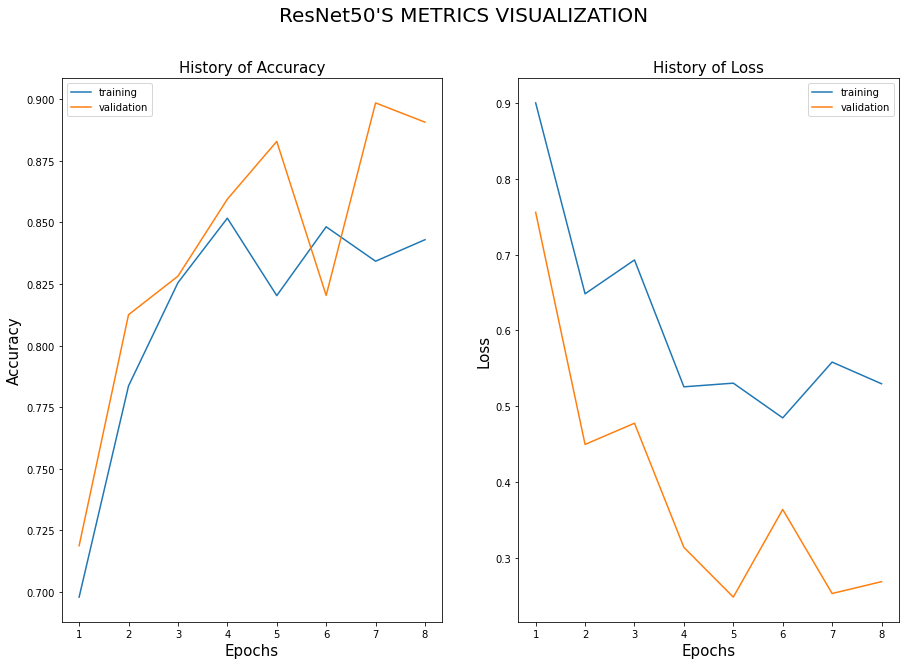

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle("ResNet50'S METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(results.history['accuracy'],results.history['val_accuracy'],
               results.history['loss'],results.history['val_loss'])

In [ ]:
import keras

final_model = keras.models.load_model('/content/drive/MyDrive/Mymodel/27ResNet50_model.h5')

**Testing on training set**

In [ ]:
nb_samples1 = train_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    #rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    #width_shift_range = 0.2,
                    #height_shift_range = 0.2,
                    #shear_range = 0.2,
                    #zoom_range = 0.2,
                    #horizontal_flip = True,
                    #vertical_flip = True,
                    #fill_mode = 'nearest'
                    )
test_generator = test_gen.flow_from_dataframe(
     train_df, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 605 validated image filenames.


In [ ]:
predictdf = final_model.predict(test_generator, steps=np.ceil(nb_samples1/BATCH_SIZE))

In [ ]:
train_df['prediction'] = np.argmax(predictdf, axis=-1)
train_df["prediction"] = train_df["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
train_df

,filename,category,prediction
0,PaperedTransparent105d.tif,marked,marked
1,PaperedControl68d.tif,marked,marked
2,PaperedControl34d.tif,marked,marked
3,PaperedTransparent27d.tif,marked,marked
4,PaperedTransparent84v.tif,marked,marked
...,...,...,...
217,NoPaperedGreen59v.tif,unmarked,unmarked
218,NoPaperedMixed32v.tif,unmarked,unmarked
219,NoPaperedGreen45d.tif,unmarked,marked
220,NoPaperedGreen23d.tif,unmarked,marked


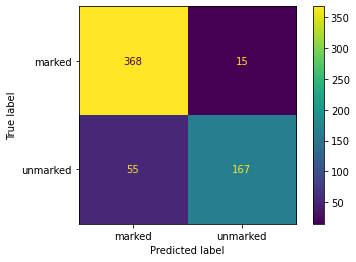

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(train_df['category'])
y_pred=list(train_df['prediction'])
cm1=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=["marked", "unmarked"])
disp.plot(values_format="d")

**Testing on validation set**

In [ ]:
to_samples = validate_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    #rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    #width_shift_range = 0.2,
                    #height_shift_range = 0.2,
                    #shear_range = 0.2,
                    #zoom_range = 0.2,
                    #horizontal_flip = True,
                    #vertical_flip = True,
                    #fill_mode = 'nearest'
                    )
test_generator1 = test_gen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 152 validated image filenames.


In [ ]:
predict = final_model.predict(test_generator1, steps=np.ceil(to_samples/BATCH_SIZE))
predict

array([[9.87357497e-01, 1.26425140e-02],
       [9.85493124e-01, 1.45068783e-02],
       [9.88194823e-01, 1.18052196e-02],
       [9.95968342e-01, 4.03167773e-03],
       [9.76790905e-01, 2.32090373e-02],
       [9.88090754e-01, 1.19091785e-02],
       [9.71090078e-01, 2.89100017e-02],
       [9.95859444e-01, 4.14059917e-03],
       [3.64849180e-01, 6.35150850e-01],
       [9.83326614e-01, 1.66733712e-02],
       [9.94343758e-01, 5.65623306e-03],
       [9.99806702e-01, 1.93263477e-04],
       [9.97968137e-01, 2.03188136e-03],
       [4.77724671e-01, 5.22275269e-01],
       [9.97684360e-01, 2.31566932e-03],
       [9.96451139e-01, 3.54889547e-03],
       [9.99214172e-01, 7.85864017e-04],
       [9.97572005e-01, 2.42800894e-03],
       [9.99737203e-01, 2.62795453e-04],
       [9.97604728e-01, 2.39524455e-03],
       [5.14219642e-01, 4.85780418e-01],
       [9.61070776e-01, 3.89292687e-02],
       [9.99572098e-01, 4.27896681e-04],
       [9.99988556e-01, 1.14426566e-05],
       [7.908057

In [ ]:
validate_df['prediction'] = np.argmax(predict, axis=1)
validate_df["prediction"] = validate_df["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
validate_df

,filename,category,prediction
0,PaperedTransparent22v.tif,marked,marked
1,PaperedTransparent88d.tif,marked,marked
2,PaperedTransparent97d.tif,marked,marked
3,PaperedMixed24d.tif,marked,marked
4,PaperedTransparent42d.tif,marked,marked
...,...,...,...
51,NoPaperedGreen76v.tif,unmarked,unmarked
52,NoPaperedGreen85d.tif,unmarked,unmarked
53,NoPaperedGreen16d.tif,unmarked,unmarked
54,NoPaperedMixed7v.tif,unmarked,marked


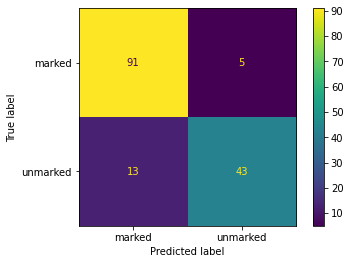

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(validate_df['category'])
y_pred=list(validate_df['prediction'])
cm=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["marked", "unmarked"])
disp.plot(values_format="d")

In [ ]:
to_samples2 = df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    #rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    #width_shift_range = 0.2,
                    #height_shift_range = 0.2,
                    #shear_range = 0.2,
                    #zoom_range = 0.2,
                    #horizontal_flip = True,
                    #vertical_flip = True,
                    #fill_mode = 'nearest'
                    )
test_generator1 = test_gen.flow_from_dataframe(
    df, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 757 validated image filenames.


In [ ]:
predict2 = final_model.predict(test_generator1, steps=np.ceil(to_samples2/BATCH_SIZE))
predict2

array([[9.9960965e-01, 3.9034869e-04],
       [9.9990296e-01, 9.6979187e-05],
       [9.9950373e-01, 4.9625110e-04],
       ...,
       [9.9998140e-01, 1.8544177e-05],
       [9.9999917e-01, 8.2182316e-07],
       [9.9979788e-01, 2.0209108e-04]], dtype=float32)

In [ ]:
df['prediction'] = np.argmax(predict2, axis=1)
df["prediction"] = df["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
df

,filename,category,prediction
0,PaperedControl21d.tif,marked,marked
1,PaperedControl22v.tif,marked,marked
2,PaperedControl22d.tif,marked,marked
3,PaperedControl23v.tif,marked,marked
4,PaperedControl23d.tif,marked,marked
...,...,...,...
752,PaperedControl19v.tif,marked,marked
753,PaperedControl19d.tif,marked,marked
754,PaperedControl20v.tif,marked,marked
755,PaperedControl20d.tif,marked,marked


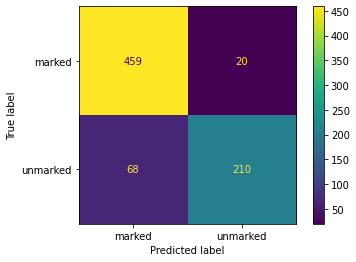

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(df['category'])
y_pred=list(df['prediction'])
cm2=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["marked", "unmarked"])
disp.plot(values_format="d")

**Random things**

In [ ]:
datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,horizontal_flip=True)
def pred(dataframe):
    for image_id in dataframe.filename:
        img = Image.open(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis/",image_id))
        img = img.resize(size)
        samples = np.expand_dims(img, axis=0)
        it = datagen.flow(samples, batch_size=BATCH_SIZE)
        yhats = final_model.predict(it, steps=np.ceil(1/BATCH_SIZE), verbose=0)
        summed = np.sum(yhats, axis=0)
    return np.argmax(summed)

predictions = pred(df)

In [ ]:
predictions

0

In [ ]:
preds=[]
for image_id in df.filename:
  image = Image.open(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis/",image_id))
  image = image.resize(size)
  image = np.expand_dims(image,axis=0)
  preds.append(np.argmax(final_model.predict(image)))
df["prediction"]=preds

In [ ]:
tmp_df1["prediction"] = tmp_df1["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1

,filename,category,prediction
594,NoPaperedMixed35v.tif,unmarked,marked
405,NoPaperedGreen22v.tif,unmarked,unmarked
655,PaperedMixed15d.tif,marked,marked
34,PaperedControl33d.tif,marked,marked
708,PaperedMixed42d.tif,marked,marked
363,PaperedTransparent104v.tif,marked,marked
516,NoPaperedGreen82v.tif,unmarked,unmarked
323,PaperedTransparent84v.tif,marked,marked
266,PaperedTransparent57v.tif,marked,marked
478,NoPaperedGreen62v.tif,unmarked,unmarked
